In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

sys.path.insert(1, os.path.join(sys.path[0], ".."))
sys.path.append('../../')
from reproduction.pipeline import load as pipeline
from reproduction.analysis import AEData

# Load Model 

In [2]:
model_dir = "/home/rlourenco/rdcep_clouds/output/m9-22_oceans/"

In [3]:
redefine_json = False
if redefine_json:
    import reproduction.models

    ae = reproduction.models.autoencoder(
        shape=(128, 128, 7),
        n_blocks=4,
        base=8,
        batchnorm=True,
        variational=False,
        block_len=0,
        nonlinearity=lambda: tf.keras.layers.Activation("relu")
    )
    with open(model_dir + "ae.json", "w") as f:
        f.write(ae.to_json())


In [4]:
def load_model(mname, summary=True):
    with open(mname + ".json", "r") as f:
        m = tf.keras.models.model_from_json(f.read())
    m.load_weights(mname + ".h5")
    m.summary()
    return m    

In [5]:
encoder = load_model(model_dir + "encoder")

/home/rlourenco/miniconda3/envs/clouds-analysis-cpu/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:764: UserWarning: models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 128, 128, 7)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 1024        encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 16)   2320        leaky_re_lu[0][0]                
__________________________________________________________________________________________________
leaky_re_l

In [6]:
decoder = load_model(model_dir + "decoder")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      (None, 8, 8, 128)    0                                            
__________________________________________________________________________________________________
leaky_re_lu_8 (LeakyReLU)       (None, 8, 8, 128)    0           decoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_transpose (Conv2DTranspo (None, 16, 16, 128)  147584      leaky_re_lu_8[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_9 (LeakyReLU)       (None, 16, 16, 128)  0           conv2d_transpose[0][0]           
__________________________________________________________________________________________________
conv2d_9 (

In [7]:
data = AEData(
    dataset=pipeline.load_data(
        data_glob="/project/foster/clouds/data/2015_05/*.tfrecord",
        shape=(128, 128, 7),
        batch_size=32,
        read_threads=4,
        shuffle_buffer_size=100,
        prefetch=2
    ),
    fields=["b%d"%(i+1) for i in range(7)],
    n=1000
)

Instructions for updating:
Use `tf.data.Dataset.batch(..., drop_remainder=True)`.


In [8]:
data.raw_encs = encoder.predict(data.imgs)
print('raw_encs: ',data.raw_encs.shape)
data.ae_imgs = decoder.predict(data.raw_encs)
print('ae_imgs: ',data.ae_imgs.shape)
data.encs = data.ae_imgs.mean(axis=(1,2))
print('encs: ',data.encs.shape)
data.compute_pca()

raw_encs:  (1000, 8, 8, 128)
ae_imgs:  (1000, 128, 128, 7)
encs:  (1000, 7)


# Residuals

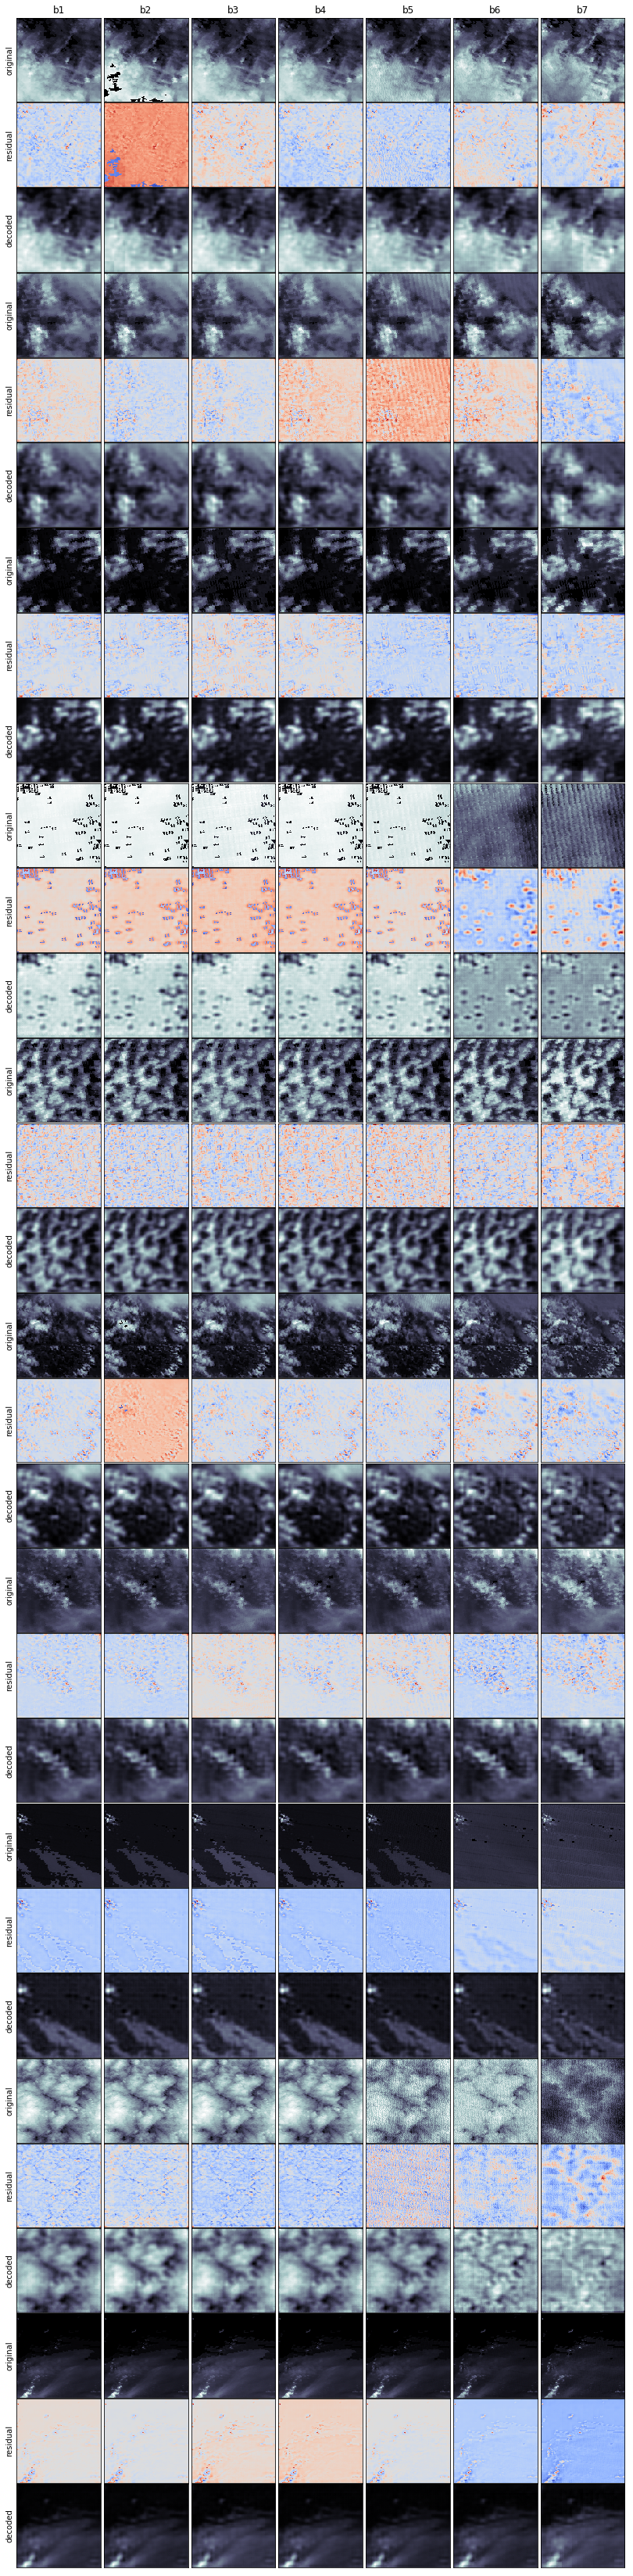

In [9]:
data.plot_residuals(n_samples=10, width=2);

# Bottleneck Activation Pattern
Recall the bottleneck representation of a patch is a `(height, width, depth)` shaped tensor where `height` and `width` are much smaller than the dimensions of the input patch and the `depth` of the bottleneck is large. The following heatmaps are the standard deviation in each pixel of the 3d bottleneck tensor. Each heatmap represents one activation channel in the depth dimension.

A linear combinatinon of these channels will be able to identify the edges of images where there is little information because we pad the convolutions. 

If an activation channel never varies then it probably is unused and the network could be smaller.

channels with a lower `depth` number seem less likely to collapse (have 0 stdev), probably because of residual connections.

In [12]:
data.raw_encs.shape

(1000, 8, 8, 128)

In [13]:
data.raw_encs.shape[-1]

128

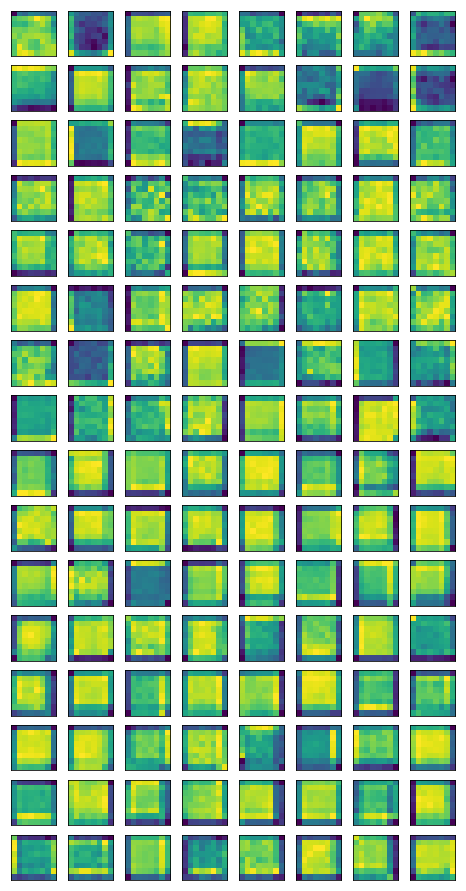

In [17]:
%matplotlib inline
nrows=16
ncols=8

assert nrows * ncols == data.raw_encs.shape[-1]

fig, ax = plt.subplots(nrows, ncols, figsize=(ncols, nrows))
for i in range(nrows):
    for j in range(ncols):
        a = ax[i,j]
        a.imshow(data.raw_encs[:, :, :, i * ncols + j].std(axis=0))
        a.set_xticks([])
        a.set_yticks([])

# Activation Correlations
We examine the correlation matrix of the activations after taking the mean of the activations over the `height` and `width` dimensions. We also throw away nan-values caused by channel collapse. Presumably these channels should not be too correlated if they represent different information.

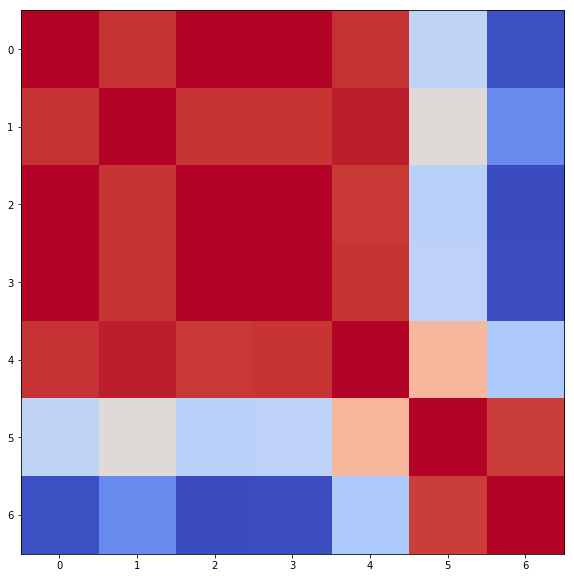

In [20]:
corr = np.corrcoef(data.encs.T)
corr_no_nan = corr[~np.isnan(corr).all(axis=0)][:, ~np.isnan(corr).all(axis=1)]
plt.figure(figsize=(10,10))
plt.imshow(corr_no_nan, cmap="coolwarm")

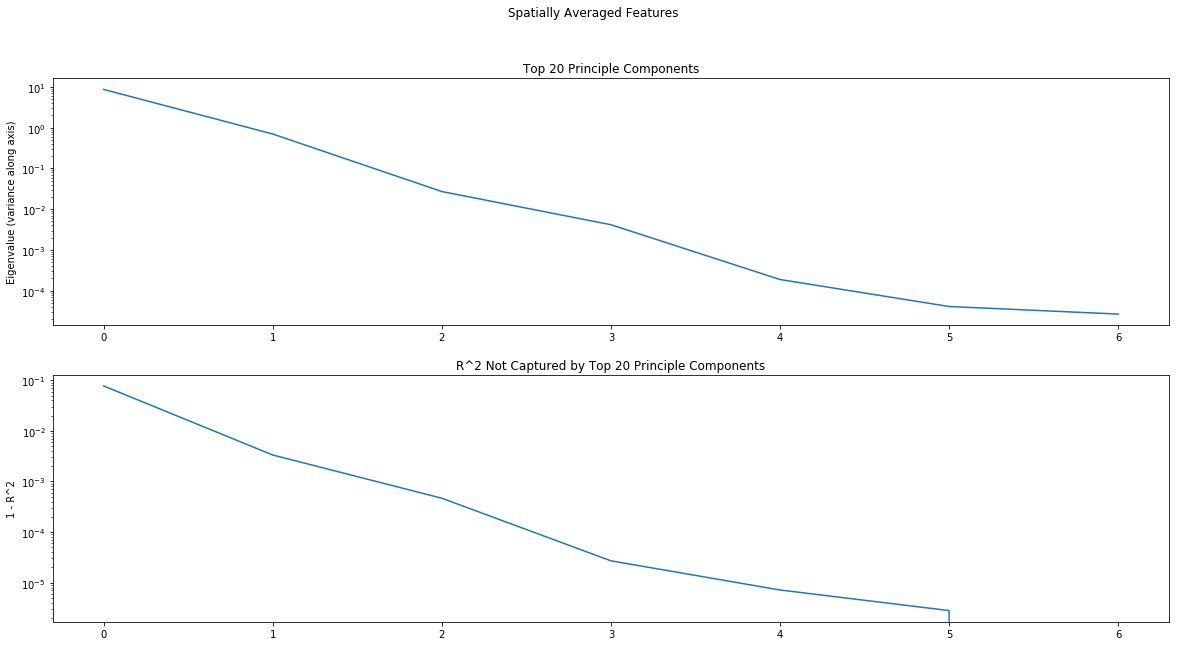

In [21]:
%matplotlib inline
D = 20
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20, 10))

ax1.plot(data._evals[:D])
ax1.set_title("Top %d Principle Components"% D)
ax1.set_yscale("log")
ax1.set_ylabel("Eigenvalue (variance along axis)")

ax2.plot(1 - data._evals.cumsum()[:D] / data._evals.sum())
ax2.set_title("R^2 Not Captured by Top %d Principle Components"%D)
ax2.set_yscale("log")
ax2.set_ylabel("1 - R^2");
fig.suptitle("Spatially Averaged Features");

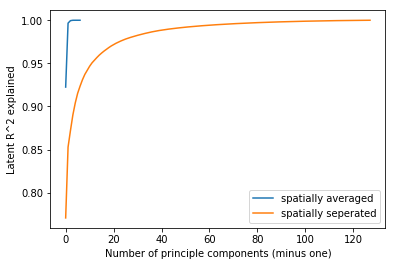

In [22]:
%matplotlib inline

data.encs = data.ae_imgs.mean(axis=(1,2))
data.compute_pca()
sp_avg_r2 = data._evals.cumsum() / data._evals.sum()

data.encs = data.raw_encs.reshape((-1, 128))
data.compute_pca()
sp_ig_r2 = data._evals.cumsum() / data._evals.sum()

plt.plot(sp_avg_r2, label="spatially averaged")
plt.plot(sp_ig_r2, label="spatially seperated")
plt.ylabel("Latent R^2 explained")
plt.xlabel("Number of principle components (minus one)")
plt.legend()

The loss due to spatially averaging is around 5% with 7-10 components in consideration. Better than the _m9cnn21-dse-henso_ experiment.